# Import, Init

In [1781]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(0, "./classes/")
import cls_nnetwork

# reloading functions without runtime.restart
import importlib
importlib.reload(cls_nnetwork)

<module 'cls_nnetwork' from './classes/cls_nnetwork.py'>

In [1782]:
# cut -- train test data with trimmed columns, so that it's more easy to train

nn_manager_cut = cls_nnetwork.NeuralManager(dir_path='../data/csv_to_train/train_test_cut/')

>>> train-test inited:  {'y_test_cut': True, 'X_test_cut': True, 'y_train_cut': True, 'X_train_cut': True}


In [1783]:
# nn_manager_cut.X_train = nn_manager_cut.X_train[['Open', 'Vol']]
# nn_manager_cut.X_test = nn_manager_cut.X_test[['Open', 'Vol']]

In [1784]:
# nn_manager_cut.X_train.drop[columns=['Open', ]]

## Normalizing

In [1785]:
from sklearn.preprocessing import RobustScaler

nn_manager_cut.normalize_X(scaler=RobustScaler)

nn_manager_cut.X_train_normalized[:2]

array([[ 4.52988659e+00,  4.78975360e+00,  4.74139303e+00,
         1.74639067e+02,  1.29200649e+00,  1.87564906e+00,
         1.23854073e-01,  3.30862295e+00, -4.16368286e-01,
        -4.19170152e+02,  2.96856492e+00,  1.36703957e+00],
       [ 3.81150200e+00,  4.42010246e+00,  4.03002493e+00,
         1.86548731e+02,  1.24667529e+00,  1.87347194e+00,
         1.72651774e+00,  2.53817428e+00, -2.38363171e-01,
        -3.08142681e+01,  3.56691540e+00,  1.54784809e+00]])

# Model 

## Unrolling data to sequences
[[to #Model-fit]](#Model-fit)

In [1786]:
sequence_len = 2
nn_manager_cut.unroll_X_to_sequences(sequence_len=sequence_len)

In [1787]:
nn_manager_cut.X_test_unrolled[0]

array([[ 3.53689240e+01,  3.51928763e+01,  3.72144714e+01,
         6.43691996e-01,  8.78219500e-01,  3.22867247e+00,
         4.83528350e-01, -2.62732657e-02, -3.42710997e-01,
        -1.29561296e-01,  2.21669940e+00,  6.36455909e-01],
       [ 3.66991727e+01,  3.66113686e+01,  3.65890404e+01,
         7.00706344e-01,  1.06493891e+00,  3.22761248e+00,
        -2.85041974e-01,  1.70764865e-01, -3.42710997e-01,
        -1.29561296e-01,  2.21669940e+00,  6.36455909e-01]])

In [1788]:
# goes up by one sequence -- compare this cell result vs previous
nn_manager_cut.X_test_unrolled[1]

array([[36.69917268, 36.61136863, 36.58904037,  0.70070634,  1.06493891,
         3.22761248, -0.28504197,  0.17076487, -0.342711  , -0.1295613 ,
         2.2166994 ,  0.63645591],
       [39.06314281, 37.9461332 , 37.46740226,  1.03303665,  1.34978675,
         3.22633882, -0.08600414,  0.52512769, -0.34168798, -0.84231242,
         1.90828686,  0.81076935]])

## Model Assembling

In [1789]:
nn_manager_cut.X_train.shape[1]

12

[n_seq-n_steps in MLM example elaboration](z_MlMastery%20LSTM%20for%20TS%20.ipynb#n_seq-n_steps)<br>
(We can parameterize this and define the number of subsequences as n_seq and the number of time steps per subsequence as n_steps. [[source]](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/#:~:text=We%20can%20parameterize%20this%20and))

### Architectures

#### CNN LSTM shape

In [1790]:
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal

n_steps_subseq = 2
n_seq = 2
n_features = nn_manager_cut.X_train.shape[1]

# CNN-LSTM
shape_cnn_lstm_train = dict(
            n_rows=nn_manager_cut.X_train_unrolled.shape[0], 
            n_seq=n_seq, 
            n_steps_subseq=n_steps_subseq, 
            n_features=n_features)

shape_cnn_lstm_test = {key:(value if key != 'n_rows' else nn_manager_cut.X_test_unrolled.shape[0]) 
                       for (key, value) in shape_cnn_lstm_train.items()}
(shape_cnn_lstm_train, shape_cnn_lstm_test)

({'n_rows': 3180, 'n_seq': 2, 'n_steps_subseq': 2, 'n_features': 12},
 {'n_rows': 793, 'n_seq': 2, 'n_steps_subseq': 2, 'n_features': 12})

#### Stacked LSTM shape
[[#Setting General seq len for X_* unrolling]](#Unrolling-data-to-sequences)

In [1791]:
# Stacked LSTM 
shape_lstm_stacked_train = dict(
            n_rows=nn_manager_cut.X_train_unrolled.shape[0], 
            n_seq=sequence_len, 
            n_features=n_features) # not splitting to subseq

shape_lstm_stacked_test = {key:(value if key != 'n_rows' else nn_manager_cut.X_test_unrolled.shape[0]) 
                       for (key, value) in shape_lstm_stacked_train.items()}

(shape_lstm_stacked_train, shape_lstm_stacked_test)

({'n_rows': 3180, 'n_seq': 2, 'n_features': 12},
 {'n_rows': 793, 'n_seq': 2, 'n_features': 12})

#### CNN-LSTM Layers

In [1792]:
# CNN-LSTM Architecture

weights_init = GlorotNormal()

conv1D_0 = Conv1D(filters=64, kernel_size=1, activation='relu', padding='same', kernel_initializer=weights_init)
conv1D_1 = Conv1D(filters=64, kernel_size=1, activation='relu', padding='same')
# conv1D_2 = Conv1D(filters=64, kernel_size=1, activation='relu', padding='causal')
# conv1D_3 = Conv1D(filters=64, kernel_size=1, activation='relu', padding='causal')

# src: 
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/#:~:text=A%20convolutional%20neural
template_CNN_LSTM = [
    TimeDistributed(conv1D_0, input_shape=(None, shape_cnn_lstm_train['n_steps_subseq'], shape_cnn_lstm_train['n_features'])),
    TimeDistributed(conv1D_1),
#     TimeDistributed(conv1D_2),
#     TimeDistributed(conv1D_3),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),
    LSTM(50, activation='relu', return_sequences = True),
    LSTM(50, activation='relu'),
    Dense(50),
    Dense(20),
    Dense(1)
]

#### Stacked LSTM Layers
[[to General Seq Len]](#Unrolling-data-to-sequences)<br>
[[to #Model-fit]](#Model-fit)

In [1793]:
# Stacked LSTM

weights_init = GlorotNormal()

template_Stacked_LSTM = [
    LSTM(50, activation='relu', 
         input_shape=(shape_lstm_stacked_train['n_seq'], shape_lstm_stacked_train['n_features']),
#          return_sequences=True, 
         kernel_initializer=weights_init),
#     LSTM(50, activation='relu', return_sequences=True),    
#     LSTM(50, activation='relu'),    
#     Dense(50),
#     Dense(5),
#     Dropout(.01),
    Dense(1)
]

In [1794]:
nn_manager_cut.X_train_unrolled.shape

(3180, 2, 12)

### Compiling Model with the chosen Architecture

In [1795]:
# Assembling and compiling model

from tensorflow import keras

opt_adam = keras.optimizers.Adam(
    learning_rate=5e-5,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False, 
)

training_params = dict(optimizer=opt_adam, loss='mean_absolute_error', metrics=['mae'])


nn_manager_cut.model_combine(template=template_Stacked_LSTM, compile_dict=training_params)

>>> model compiled
Model: "sequential_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_289 (LSTM)              (None, 50)                12600     
_________________________________________________________________
dense_397 (Dense)            (None, 1)                 51        
Total params: 12,651
Trainable params: 12,651
Non-trainable params: 0
_________________________________________________________________


True

## Model Training

In [1796]:
# CNN-LSTMs DataShapes
data_shape_cnn_lstm_train = (
    shape_cnn_lstm_train['n_rows'], 
    shape_cnn_lstm_train['n_seq'], 
    shape_cnn_lstm_train['n_steps_subseq'],
    shape_cnn_lstm_train['n_features']
)
data_shape_cnn_lstm_test = (
    shape_cnn_lstm_test['n_rows'], 
    shape_cnn_lstm_test['n_seq'], 
    shape_cnn_lstm_test['n_steps_subseq'],
    shape_cnn_lstm_test['n_features']
)
(data_shape_cnn_lstm_train, data_shape_cnn_lstm_test)

((3180, 2, 2, 12), (793, 2, 2, 12))

In [1797]:
# LSTMs Stacked DataShapes
data_shape_lstm_stacked_train = (
    shape_lstm_stacked_train['n_rows'], 
    shape_lstm_stacked_train['n_seq'],
    shape_cnn_lstm_train['n_features']
)
data_shape_lstm_stacked_test = (
    shape_cnn_lstm_test['n_rows'], 
    shape_lstm_stacked_train['n_seq'],
    shape_cnn_lstm_test['n_features']
)
(data_shape_lstm_stacked_train, data_shape_lstm_stacked_test)

((3180, 2, 12), (793, 2, 12))

#### Model fit

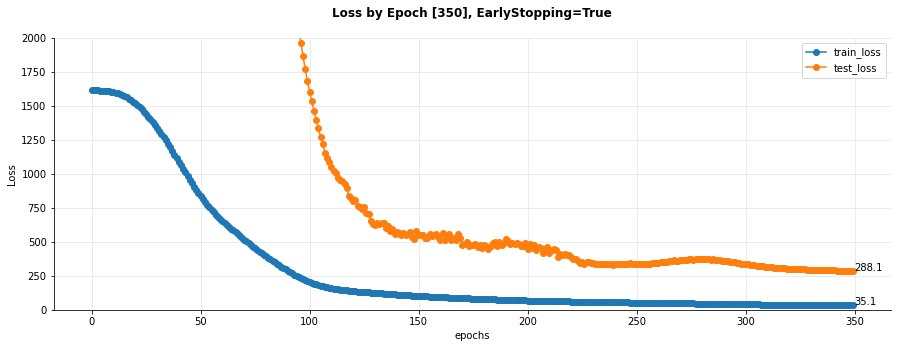

In [1798]:
# %%time
nn_manager_cut.model_fit(n_epoch=350,
                           data_shape_train=data_shape_lstm_stacked_train,
                           data_shape_test=data_shape_lstm_stacked_test,
                           verbose=0, 
                           return_results=True, 
                           print_charts=True,
                           early_stopping=True
                        );
plt.ylim(0,2e3);

Architectures: <br>
[[#CNN-LSTM_Architecture]](#CNN-LSTM-Layers)<br>
[[#Stacked-LSTM_Architecture]](#Stacked-LSTM-Layers)

Adam Compiler setup [[go]](#Compiling-Model-with-the-chosen-Architecture)

In [1817]:
from datetime import datetime

nn_manager_cut.model.save(f'./saved_models/{datetime.now().strftime("%Y%m%d_%HH%MM%SS")}')

INFO:tensorflow:Assets written to: ./saved_models/20210617_12H11M34S/assets


# Playground

In [1799]:
# sh = nn_manager_cut.X_test_unrolled[1].shape

# X_pred = nn_manager_cut.X_test_unrolled[1].reshape(int(sh[0]/n_steps_subseq), n_steps_subseq, n_features)

